# Stroke Prediction
Stroke is the 2nd highest cause of mortality in the world (WHO). Even if an individual survives a stroke, it is common that the individual has severe symptoms such as spasticity, cognitive problems etc.

Since stroke is a major health problem, it is crucial to know the risk factors that cause a stroke.In this dataset, we will investigate these factors and build a model that predicts stroke.

The data set contains 11 features and 1 target variable. The target variable is 'Stroke' column, which is binary data 0: No stroke, 1 : Stroke.  

This notebook includes EDA of the data


#### Importing packages 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import numpy as np
from scipy import stats

pd.set_option('display.max_columns', 60)


import warnings
warnings.filterwarnings("ignore")

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder

# metrics
from sklearn.metrics import accuracy_score, classification_report, auc, make_scorer
from sklearn.metrics import confusion_matrix, recall_score 
from sklearn.metrics import f1_score, precision_score, roc_curve, precision_recall_curve, roc_auc_score

# folds
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

#ml models
# dummy classifier
from sklearn.dummy import DummyClassifier
#other classifiers
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

In [3]:
# Read the csv file
url = "https://raw.githubusercontent.com/orkunaran/Stroke-Prediction/main/healthcare-dataset-stroke-data.csv"
path = "healthcare-dataset-stroke-data.csv"
df = pd.read_csv(path)

In [4]:
# First and last 5 rows of the data
display(df.head())

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [5]:
print('The Stroke data has {0} rows and {1} columns'.format(df.shape[0],df.shape[1]))

The Stroke data has 5110 rows and 12 columns


Let's see;
The data consists of 5110 rows and 12 columns. The first column is 'ID' column, we might want to remove this. Then, the other columns seems to be categorical variables except Age, glucose level and BMI. We will get the info of the data, just in case if there is any unsuitable types.

After that, we should investigate missing values if there is any; and see the proportion of the missings.

## Investigating Target Variable

In [6]:
# Since this is a classification problem, let's investigate the proportion of stroke variables.
df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

4861 vs 249. We have Class Imbalance here. From what I learnt (tnx google and youtube),  We can use Spread SubSampling or  Synthetic Minority Over-sampling Technique (SMOTE). Spread SubSampling means that we will delete some rows which had 0 (no stroke) value. However I don't think this is a good idea for this dataset, because the number of  participants with stroke is 227; and we need to delete nearly 4400 rows. So I think it is better to use SMOTE and have a decent number of data

We'll handle this after dealing with missings.

In [7]:
# remove Id columns and investigate column types
df.drop(['id'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


The data types seem good. No changes needed

In [8]:
# investigate the means, medians, min-max of the data.
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Age column seem to have an issue. 0.08 years of age might be wrong, we'll dive into that.  Also, 10 BMI would be wrong too, but we need to see if it's ok or not. I really wished that data had weight an height informations as well.

In [9]:
missings = pd.DataFrame(columns=['Columns','Missing','Percentage'])

In [10]:
for x in df.columns:
    if df[x].isna().sum() >0:
        missings = missings.append({'Columns': x ,'Missing': df[x].isna().sum(), 
                                    'Percentage':(df[x].isna().sum()/len(df[x])*100)}, ignore_index=True)

In [11]:
missings

,Columns,Missing,Percentage
0,bmi,201,3.933464


only BMI column has missings and it's really a low proportion of the data. We will use KNN imputation to predict the missings , or easily we will fill them with means; but i want to learn KNN here, so I will use it after spliting the dataset.

## Outlier detection 

In [12]:
# possible outliers are in Age and BMI columns as mentioned above. 

In [13]:
# Reference to Ceren İyim github, link : https://github.com/cereniyim/Tree-Classification-ML-Model
def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(df[col_name], 25)
    third_quartile = np.percentile(df[col_name], 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(1.5*IQR)
    lower_limit = first_quartile-(1.5*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

In [14]:
numerics= df.select_dtypes(include='float64')
for column in numerics.columns:
    if outlier_function(numerics, column)[2] > 0:
        print("There are {} outliers in {}".format(outlier_function(df, column)[2], column))

There are 627 outliers in avg_glucose_level


In [15]:
#I want to investigate age columns additionally, although there was no outliers detected. The ages below 1 may be problem
age_invest = df[df['work_type']=='children']
display(age_invest)
age_invest.describe()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
245,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1
249,Male,3.00,0,0,No,children,Rural,95.12,18.0,Unknown,0
282,Female,3.00,0,0,No,children,Urban,73.74,16.0,Unknown,0
290,Male,13.00,0,0,No,children,Urban,114.84,18.3,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
5089,Female,0.72,0,0,No,children,Rural,62.13,16.8,Unknown,0
5094,Male,13.00,0,0,No,children,Urban,82.38,24.3,Unknown,0
5095,Male,1.08,0,0,No,children,Rural,79.15,17.4,Unknown,0
5098,Male,9.00,0,0,No,children,Urban,71.88,17.5,Unknown,0


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,687.000000,687.0,687.000000,687.000000,671.000000,687.000000
mean,6.841339,0.0,0.001456,94.400277,20.038003,0.002911
std,4.533364,0.0,0.038152,26.658955,4.540639,0.053916
min,0.080000,0.0,0.000000,55.340000,10.300000,0.000000
25%,2.000000,0.0,0.000000,76.255000,17.150000,0.000000
50%,6.000000,0.0,0.000000,90.220000,18.900000,0.000000
75%,11.000000,0.0,0.000000,108.710000,21.600000,0.000000
max,16.000000,0.0,1.000000,219.810000,41.700000,1.000000


It is obvious that I was wrong about the age issue; the ages below 0 is months converted to years, and these values are children's data. So I would keep age data as it is

TLDR: age columns is good, back to outlier removal.

In [16]:
stroke = df[df['stroke']==1]
no_stroke = df[df['stroke']==0]

no_stroke

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
249,Male,3.0,0,0,No,children,Rural,95.12,18.0,Unknown,0
250,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
251,Female,8.0,0,0,No,Private,Urban,110.89,17.6,Unknown,0
252,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
253,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [17]:
for col in no_stroke.select_dtypes(include='float64').columns:
    if outlier_function(no_stroke, col)[2] > 0:
        print("There are {} outliers in {}".format(outlier_function(no_stroke, col)[2], col))
        

There are 551 outliers in avg_glucose_level


In [18]:
lower_limit, upper_limit, outlier_count = outlier_function(no_stroke, 'avg_glucose_level')
lower_limit, upper_limit, outlier_count

no_stroke = no_stroke[(no_stroke['avg_glucose_level'] < upper_limit) &
                  (no_stroke['avg_glucose_level'] > lower_limit)]


In [19]:
df = pd.concat([stroke,no_stroke])

In [20]:
#Before graphs, lets see the means of the two groups (stroke and healthy)
means = df.loc[:,['age','avg_glucose_level','bmi','stroke']]
counts = df.loc[:,['gender', 'hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status','stroke']]
display(df['stroke'].value_counts())
display(means.groupby(means['stroke']).mean())
display(counts.groupby(counts['stroke']).sum())

0    4310
1     249
Name: stroke, dtype: int64

,age,avg_glucose_level,bmi
stroke,,,
0,39.886766,91.279102,28.293451
1,67.728193,132.544739,30.471292


,hypertension,heart_disease
stroke,,
0,298,152
1,66,47


People who had a stroke is older, has higher blood sugar rates and slightly higher BMI. 

In [21]:
display('the percentage of stroke in the data set is :', sum(df['stroke']==1)*100/len(df))

'the percentage of stroke in the data set is :'

5.461724062294363

According to Global burden disease reports Stroke prevelance in the world is 1,180.40 per 100,000 population. Which is 1.12%. 

Reference: https://www.world-stroke.org/assets/downloads/WSO_Fact-sheet_15.01.2020.pdf

However, to make appropriate predictions, we need more data from Stroke feature. As mentioned above I will use SMOTE to estimate/create more data.

#### Future update:

I read a lot about resampling of the data, and most of the data scientists claim that resampling would do no good in real world situations. I will try different ML approaches with class weights, or similar parameters.

## Data Visualition

### All data visuals

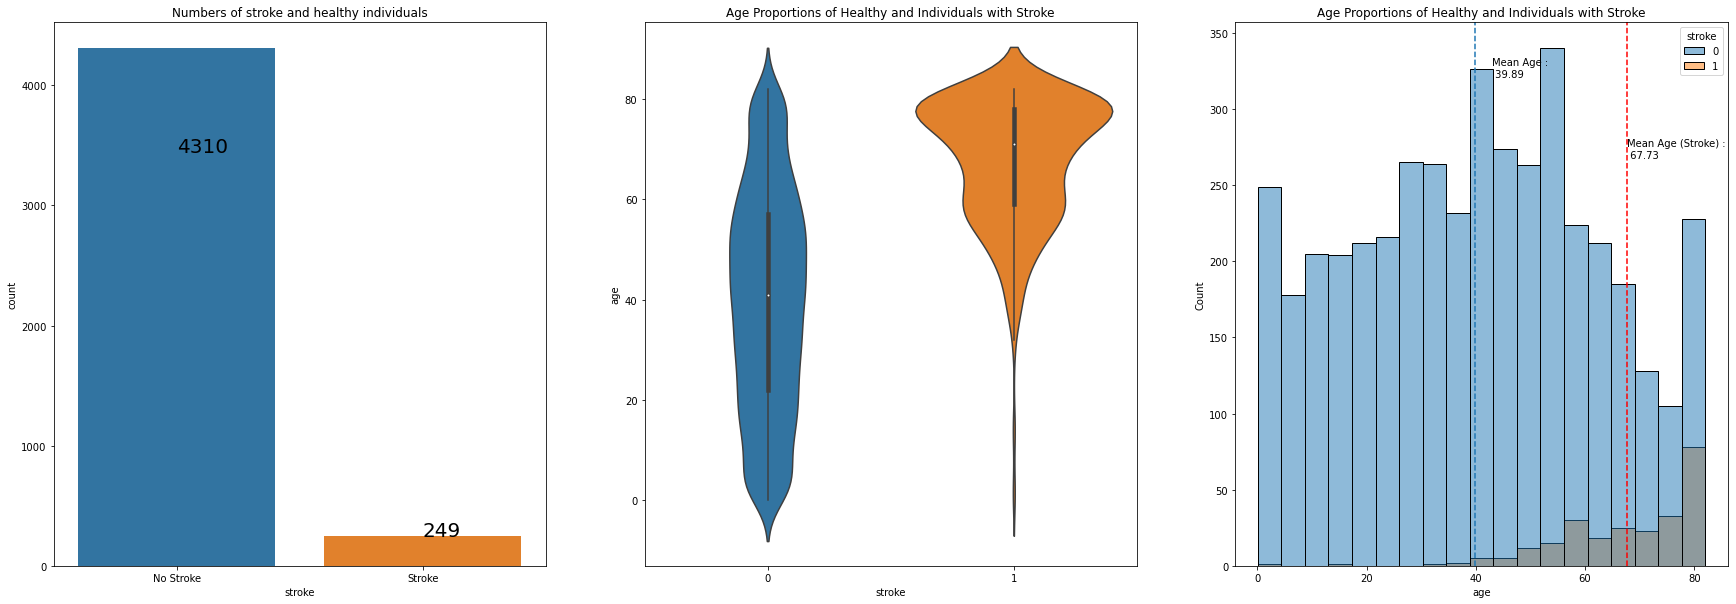

In [22]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(30,10))

sns.countplot(x = df['stroke'], ax = ax1)
ax1.set_xticklabels( ['No Stroke', 'Stroke'])
ax1.set_title('Numbers of stroke and healthy individuals')
ax1.text( s = df['stroke'].value_counts()[0],
         x = 0,
         y = (df['stroke'].value_counts()[0]) * 0.8,
        fontsize = 20)

ax1.text( s = df['stroke'].value_counts()[1],
         x = 1,
         y = (df['stroke'].value_counts()[1]),
        fontsize = 20)

sns.violinplot(x=df['stroke'], y=df['age'], ax = ax2)
ax2.set_title('Age Proportions of Healthy and Individuals with Stroke')


sns.histplot(data = df, x = 'age', hue='stroke', ax = ax3)
miny_lim, y_lim = plt.ylim()
ax3.axvline(df[df['stroke']==1]['age'].mean(), linestyle='--', color='r')
ax3.axvline(df[df['stroke']==0]['age'].mean(), linestyle='--')
ax3.text(s = f"Mean Age (Stroke) : \n {df[df['stroke']==1]['age'].mean():.2f}",
         y = y_lim * 0.75, x =df[df['stroke']==1]['age'].mean() )
ax3.text(s = f"Mean Age : \n {df[df['stroke']==0]['age'].mean():.2f}",
         y = y_lim * 0.9, x =df[df['stroke']==0]['age'].mean()+3 )
ax3.set_title('Age Proportions of Healthy and Individuals with Stroke')

plt.show()

It seems, stroke is morelikely to occur at older ages. (yes, i know this is too obvious)

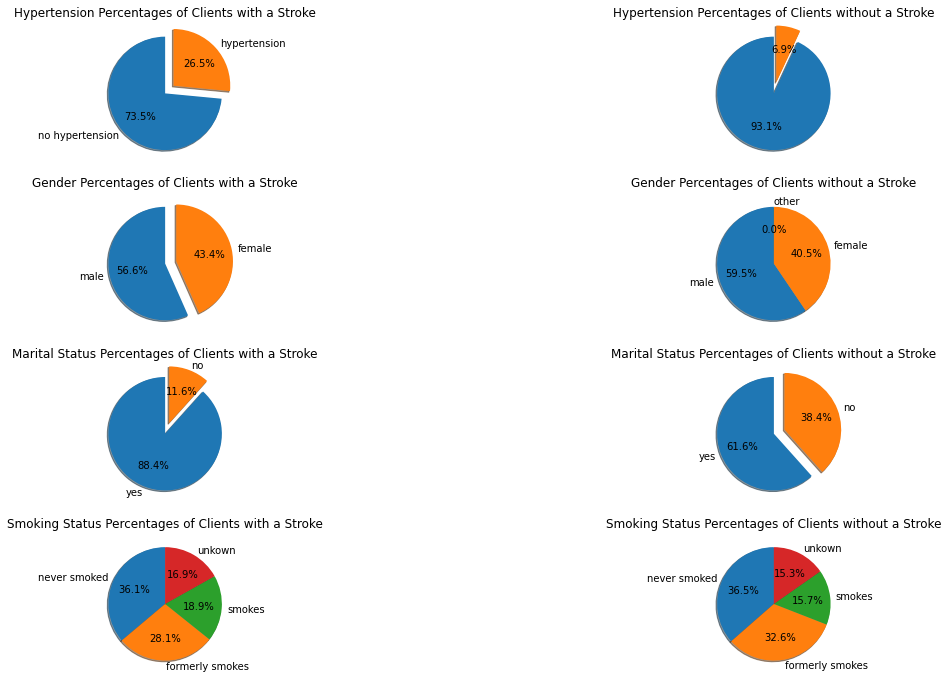

In [23]:
strokes = df[df['stroke']==1]
no_stroke = df[df['stroke']==0]
fig, ax = plt.subplots(4,2, figsize=(20,12))

ax[0,0].pie(strokes['hypertension'].value_counts(normalize=True),
           autopct= '%1.1f%%',
           shadow = True,
            labels = ['no hypertension', 'hypertension'],
           startangle = 90,
           explode = [0,0.2])
ax[0,0].set_title('Hypertension Percentages of Clients with a Stroke')

ax[0,1].pie(no_stroke['hypertension'].value_counts(normalize=True),
           autopct= '%1.1f%%',
           shadow = True,
           startangle = 90,
           explode = [0,0.2])
ax[0,1].set_title('Hypertension Percentages of Clients without a Stroke')

ax[1,0].pie(strokes['gender'].value_counts(normalize=True),
           autopct= '%1.1f%%',
           shadow = True,
           labels = ['male', 'female'],
           startangle = 90,
           explode = [0,0.2])
ax[1,0].set_title('Gender Percentages of Clients with a Stroke')

ax[1,1].pie(no_stroke['gender'].value_counts(normalize=True),
           autopct= '%1.1f%%',
           shadow = True,
            labels = ['male', 'female', 'other'],
           startangle = 90,
           )
ax[1,1].set_title('Gender Percentages of Clients without a Stroke')


ax[2,0].pie(strokes['ever_married'].value_counts(normalize=True),
           autopct= '%1.1f%%',
           shadow = True,
            labels = ['yes', 'no'],
           startangle = 90,
           explode = [0,0.2])
ax[2,0].set_title('Marital Status Percentages of Clients with a Stroke')


ax[2,1].pie(no_stroke['ever_married'].value_counts(normalize=True),
           autopct= '%1.1f%%',
           shadow = True,
            labels = ['yes', 'no'],
           startangle = 90,
           explode = [0,0.2])
ax[2,1].set_title('Marital Status Percentages of Clients without a Stroke')

ax[3,0].pie(strokes['smoking_status'].value_counts(normalize=True),
           autopct= '%1.1f%%',
           shadow = True,
           labels = ['never smoked', 'formerly smokes', 'smokes','unkown'],
           startangle = 90,
           #explode = [0,0.2]
           )
ax[3,0].set_title('Smoking Status Percentages of Clients with a Stroke')

ax[3,1].pie(no_stroke['smoking_status'].value_counts(normalize=True),
           autopct= '%1.1f%%',
           shadow = True,
          labels = ['never smoked', 'formerly smokes', 'smokes','unkown'],
           startangle = 90,
           #explode = [0,0.2]
           )
ax[3,1].set_title('Smoking Status Percentages of Clients without a Stroke')



plt.show()

## Observations of Plots

As we can see from the pie charts;

* Clients with a stroke has higher hypertension rates than the clients with no stroke

* We cannot tell anything from the gender distrubitions; however according to literature Male gender has higher chance to have a stroke 

* Let's make a bias here : IF YOU ARE MARRIED, YOU ARE MORE LIKELY TO HAVE A STROKE :) 
        
        Well it is hard to say that. 
        
        Let's recall the histogram that we plot for age distributions. The clients with stroke had higher age means than the clients with no stroke. It is more likely someone to get married after a certain age.  So , I wouldn't say that marriage affects the possibility to have a stroke or not.
        
* Nearly all groups has similar proportions, however smokers are higher in the ones had a stroke. And again, it is hard to conclude 'Smoking increases your chances to have a stroke' from this dataset. 

* And yet again, we cannot make an assumption from the obesity levels. Maybe we can create labels from obesity data. 

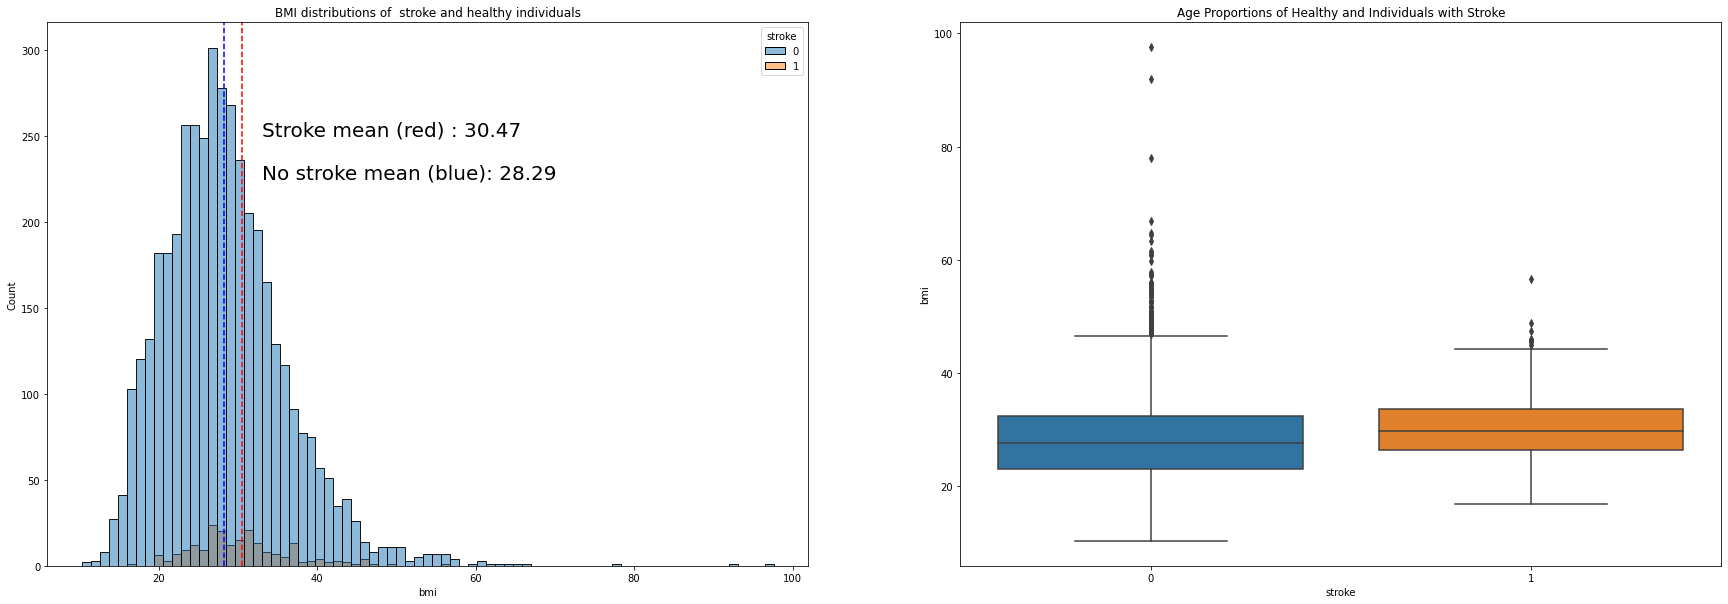

In [24]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(30,10))

sns.histplot(data = df, x= 'bmi', hue= 'stroke', ax = ax1)
ax1.set_title('BMI distributions of  stroke and healthy individuals')
ax1.text( s = 'Stroke mean (red) : ' "{:.2f}".format(strokes['bmi'].mean()),
         x = 33,
         y = 250,
       fontsize = 20)

ax1.text( s = 'No stroke mean (blue): ' "{:.2f}".format(no_stroke['bmi'].mean()),
         x = 33,
         y = 225,
       fontsize = 20)
ax1.axvline(strokes['bmi'].mean(), linestyle='--', color='r')
ax1.axvline(no_stroke['bmi'].mean(), linestyle='--', color='b')

sns.boxplot(x=df['stroke'], y=df['bmi'], ax = ax2)
ax2.set_title('Age Proportions of Healthy and Individuals with Stroke')



plt.show()
# the clients who had a stroke gathered around 30 bmi, means are close

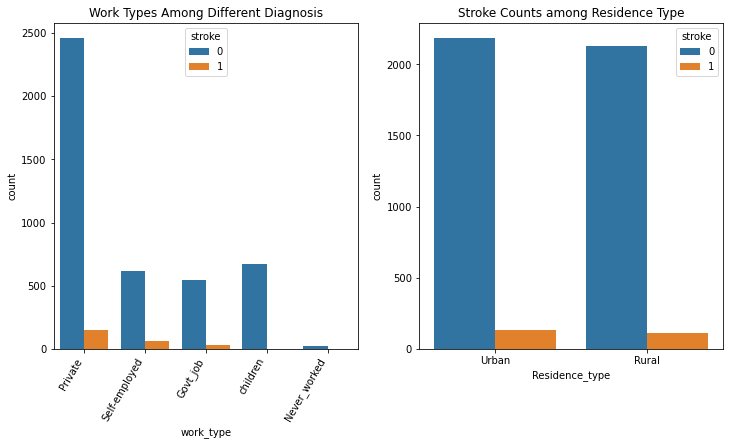

In [25]:
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(12,6))
sns.countplot(x= 'work_type', hue= 'stroke', data=df, ax=ax1)
_ = ax1.set_xticklabels(labels = df['work_type'].unique(),rotation=60, ha='right')
ax1.set_title('Work Types Among Different Diagnosis')

sns.countplot(x= 'Residence_type', hue= 'stroke', data=df, ax = ax2)
_ = ax2.set_title('Stroke Counts among Residence Type')

plt.show()

Work Type : I don't know how things work in the country where the data gathered, But I assume private sector and running your own work is a stresfull thing to earn a position in competative environment, rather than government job. 

Residence : Seems where you live is not that important on having a stroke

In [26]:
def bayesian_dist(column, data):
    """this function gets column name (str) and dataframe (str), 
    returns distribution plot of the column, skewness and kurtosis"""
    sns.distplot(data[column])
    plt.title(x)
    plt.show()
    plt.show()
    print('skewness: ', stats.skew(data[column]))
    print('kurtosis: ', stats.kurtosis(data[column]))
    

def normal_visual(column, df):
    """This function gets column and dataframe as str.
    Return 
    Shapiro Wilk test and Kolmogorov-Smirnov test results,
    distplot, skewness and kurtosis of the column
    """
    bayesian_dist(column, df)
    print('*'* 30)
    print(column, 'Shapiro-Wilk test t score: ', "{:.2f}".format(stats.shapiro(df[x])[0]))
    print(column, 'Shapiro-Wilk test p value: ', "{:.2f}".format(stats.shapiro(df[x])[1]))
    print('*'*30)
    print(column, 'Kolmogorov-Smirnov t score: ', "{:.2f}".format(stats.kstest(df[x],'norm', args=(df[x].mean(),
                                                                                                   df[x].std()))[0]))
    print(column, 'Kolmogorov-Smirnov t score: ', "{:.2f}".format(stats.kstest(df[x],'norm', args=(df[x].mean(),
                                                                                                   df[x].std()))[1]))
    
    

We will accept the data normally distributed if Skewness is in range -0.5,0.5 and Kurtosis -3,3

Skewness and kurtosis seem ok (except bmi), but histograms doesn't show normal dist. 

let's investigate p values. p>0.05 is accepted as Normal dist. So age and bmi might be normally distributed, however glucose level is not. Now let's see Kolmogorov-smirnov test results which is an other way to examine ND.

KS test results also indicate no ND of these data. 



In [27]:
# save cleaned csv file for predictions
df.to_csv('')

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0
